# 猫狗大战

* 题目要求: 识别一张图片时猫还是狗
* 输出:是狗的可能性(0-1.0)

一个二分类的问题,这种类型做起来方法很多,因为既可以当作分类问题(0,1,两个类别),也可以把他当作回归问题(输入0-1.0的一个实数)

下面就分类讨论一下

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn import linear_model, svm, preprocessing, decomposition, model_selection
import seaborn as sns
%matplotlib inline 

## 预处理数据

> 题目给的数据是以文件夹内图片文件的形式,标签与id在文件名内,我们先获取不同类别和测试数据的文件名组

In [54]:
BASEPATH="D:/dataset/dogcat/"
TRAINDIR = BASEPATH+'train/'
TESTDIR = BASEPATH+'test/'

all_train_images = [TRAINDIR+i for i in os.listdir(TRAINDIR)] 
random.shuffle(all_train_images)# 打乱,因为列文件是按文件名排序的

train_dogs_images =   [TRAINDIR+i for i in os.listdir(TRAINDIR) if 'dog' in i]
train_cats_images =   [TRAINDIR+i for i in os.listdir(TRAINDIR) if 'cat' in i]

all_test_images =  [TESTDIR+i for i in os.listdir(TESTDIR)];

看下数量

In [55]:
print("训练集数:"+str(len(all_train_images)))
print("猫的数量:"+str(len(train_cats_images)))
print("狗的数量:"+str(len(train_dogs_images)))
print("测试集数:"+str(len(all_test_images)))

训练集数:25000
猫的数量:12500
狗的数量:12500
测试集数:12500


载入图片

(332, 499, 3)

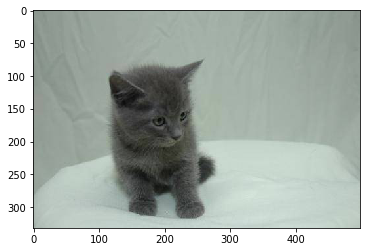

In [56]:
acat=plt.imread(BASEPATH+"train/cat.11306.jpg")
plt.imshow(acat)
acat.shape

喵喵喵?

首先它是一张彩色图像,大小是408*500的,这里有两个问题:是不是所有图片大小一样,还有这图片对于我们来说太大了(一张图片就有1w多个特征,就算用$O(nlogn)$的算法也太慢了)

先来看下大小

In [57]:
for i in range(50):
    print(plt.imread(all_train_images[i]).shape)

(473, 462, 3)
(374, 318, 3)
(313, 316, 3)
(376, 500, 3)
(374, 500, 3)
(465, 431, 3)
(499, 325, 3)
(239, 320, 3)
(500, 389, 3)
(117, 182, 3)
(374, 500, 3)
(337, 499, 3)
(375, 499, 3)
(239, 320, 3)
(375, 499, 3)
(374, 500, 3)
(257, 200, 3)
(219, 500, 3)
(466, 499, 3)
(362, 385, 3)
(500, 428, 3)
(300, 226, 3)
(430, 349, 3)
(94, 124, 3)
(375, 499, 3)
(328, 222, 3)
(499, 317, 3)
(255, 321, 3)
(337, 499, 3)
(375, 499, 3)
(374, 500, 3)
(479, 497, 3)
(396, 369, 3)
(334, 499, 3)
(374, 500, 3)
(375, 499, 3)
(364, 316, 3)
(499, 415, 3)
(375, 499, 3)
(499, 375, 3)
(363, 431, 3)
(496, 499, 3)
(374, 499, 3)
(198, 162, 3)
(431, 288, 3)
(500, 492, 3)
(351, 499, 3)
(374, 500, 3)
(375, 499, 3)
(259, 190, 3)


大小不一样,比例不一样,很多模型和算法的输入形状都要保证一样,所以我们对图片进行预处理

三步:
+ 统一缩放到64*64
+ 去除三通道,使用灰度通道
+ 归一化

In [58]:

IMGROW=64
IMGCOL=64
def preimage(imgpath):
    '''输入图片路径,返回处理后的图片对象'''
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    data=cv2.resize(img, (IMGROW, IMGCOL), interpolation=cv2.INTER_CUBIC)
    return preprocessing.normalize(data)

测试一下

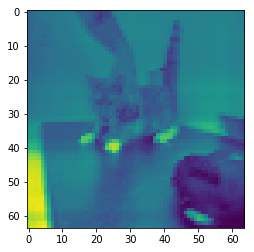

In [59]:
plt.imshow(preimage(train_cats_images [0]))

我们先生成训练集

In [88]:
TRYSIZE=10000#测试用大小,提高速度
X=[]
Y=[]
for i in range(TRYSIZE):
    filename=all_train_images[i]
    imgdata=preimage(filename)
    label= 1 if "dog." in filename else 0
    X.append(imgdata)
    Y.append(label)

验证集可以大一点

In [64]:
TESTSIZE=10000
test_X=[]
test_Y=[]
for i in range(TRYSIZE,TESTSIZE+TRYSIZE):
    filename=all_train_images[i]
    imgdata=preimage(filename)
    label= 1 if "dog." in filename else 0
    test_X.append(imgdata)
    test_Y.append(label)
test_X=np.array(test_X)
test_Y=np.array(test_Y)
(test_X.shape,test_Y.shape)

((10000, 64, 64), (10000,))

In [89]:
X=np.array(X)
Y=np.array(Y)
(X.shape,Y.shape,Y)

((10000, 64, 64), (10000,), array([0, 1, 1, ..., 0, 0, 1]))

## 搭建模型

### 简单的贝叶斯模型 

In [25]:
from sklearn import linear_model
reg = linear_model.BayesianRidge()
X_reg=X.reshape(1000,4096)
reg.fit(X_reg+0.000001, Y+0.00001)

C:\anaconda\envs\kaggle180629\lib\site-packages\sklearn\linear_model\bayes.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_ = 1. / np.var(y)
C:\anaconda\envs\kaggle180629\lib\site-packages\sklearn\linear_model\bayes.py:212: RuntimeWarning: invalid value encountered in true_divide
  (lambda_ + alpha_ * eigen_vals_)))


KeyboardInterrupt: 

In [21]:
out=reg.predict(test_X.reshape(10000,4096))

In [22]:
def loss(Yp,Yt):
    return - np.array([Yt[i]*np.log(Yp[i]+0.00000000001)+(1-Yt[i])*np.log(1-Yp[i]+0.0000000001) for i in range(len(Yp))]).mean()
loss([0.5]*10000,test_Y)

0.6931471805399453

In [23]:
loss(out,test_Y)

nan

几乎没效果,因为是线性模型

In [28]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_reg,Y).predict(test_X.reshape(10000,4096))

In [29]:
loss(y_pred,test_Y)

-1.0000000827353709e-11

来一个简单的神经网络

In [31]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [71]:
model = Sequential()
model.add(Conv2D(64, (3,3),padding='same',input_shape=(1,64,64),data_format="channels_first")) 
model.add(Activation('relu')) #激活层
model.add(Conv2D(64, (3, 3),data_format="channels_first")) 
model.add(Activation('relu')) #激活层
model.add(Dropout(0.25)) #神经元随机失活
model.add(MaxPooling2D(pool_size=(2,2),data_format="channels_first")) #池化层

model.add(Conv2D(64, (3,3),padding='same',data_format="channels_first")) 
model.add(Activation('relu')) #激活层
model.add(Conv2D(64, (3, 3),data_format="channels_first")) 
model.add(Activation('relu')) #激活层
model.add(MaxPooling2D(pool_size=(2,2),data_format="channels_first")) #池化层
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_crossentropy'])

In [86]:
model = Sequential()
model.add(Conv2D(64, (5, 5),padding='same',input_shape=(1,64,64)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
#第二个卷积层，8个卷积核，每个卷积核大小3*3。4表示输入的特征图个数，等于上一层的卷积核个数
#激活函数用relu
#采用maxpooling，poolsize为(2,2)
model.add(Conv2D(8, (3, 3),data_format="channels_first"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
#第三个卷积层，16个卷积核，每个卷积核大小3*3
#激活函数用relu
#采用maxpooling，poolsize为(2,2)
model.add(Conv2D(16, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
#全连接层，先将前一层输出的二维特征图flatten为一维的。
#全连接有128个神经元节点,初始化方式为normal
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#sigmoid分类，输出是2类别
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

C:\anaconda\envs\kaggle180629\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
  


In [ ]:
h=model.fit(X.reshape(10000,1,64,64), Y, batch_size=128, nb_epoch=10,
              validation_split=0.25, verbose=1, shuffle=True)

C:\anaconda\envs\kaggle180629\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 3s 462us/step - loss: 0.6846 - acc: 0.5555 - val_loss: 0.6734 - val_acc: 0.5836
Epoch 2/10
7500/7500 [==============================] - 2s 313us/step - loss: 0.6744 - acc: 0.5804 - val_loss: 0.6624 - val_acc: 0.6024
Epoch 3/10
7500/7500 [==============================] - 2s 318us/step - loss: 0.6732 - acc: 0.5820 - val_loss: 0.6743 - val_acc: 0.5656
Epoch 4/10
7500/7500 [==============================] - 2s 305us/step - loss: 0.6706 - acc: 0.5843 - val_loss: 0.6660 - val_acc: 0.5936
Epoch 5/10
7500/7500 [==============================] - 2s 313us/step - loss: 0.6673 - acc: 0.5927 - val_loss: 0.6572 - val_acc: 0.6016
Epoch 6/10
7500/7500 [==============================] - 2s 305us/step - loss: 0.6662 - acc: 0.5981 - val_loss: 0.6571 - val_acc: 0.6148
Epoch 7/10
7500/7500 [==============================] - 2s 306us/step - loss: 0.6611 - acc: 0.5991 - val_loss: 0.6578 - val_acc: 0.6156


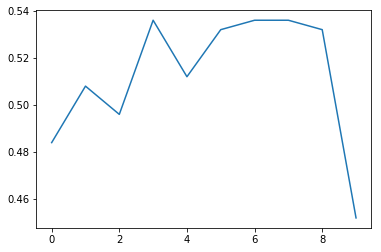

In [85]:
plt.plot(h.history["val_acc"])

In [37]:
p=model.predict(test_X.reshape(10000,1,64,64), verbose=1)

10000/10000 [==============================] - 19s 2ms/step


In [51]:
p,test_Y

(array([[0.99996686],
        [0.99996495],
        [0.9999701 ],
        ...,
        [0.99996376],
        [0.9999615 ],
        [0.99997175]], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

In [38]:
loss(p,test_Y)

4.214772e-05

## 预测测试集与输出

In [39]:
T=[]
Tid=[]
for i in all_test_images:
    Tid.append(int(os.path.split(i)[1][:-4]))
    T.append(preimage(i))

In [42]:
T=np.array(T)

In [44]:
T.shape

(12500, 64, 64)

In [45]:
p=model.predict(T.reshape(-1,1,64,64), verbose=1)

12500/12500 [==============================] - 23s 2ms/step


In [48]:
sub=pd.DataFrame({"id": Tid, "label": p.flatten()})

In [49]:
sub

,id,label
0,1,0.999967
1,10,0.999965
2,100,0.999970
3,1000,0.999965
4,10000,0.999975
5,10001,0.999916
6,10002,0.999973
7,10003,0.999971
8,10004,0.999970
9,10005,0.999972
